In [2]:
import re
import string
import csv
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_numeric
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import treebank
from nltk.tag import hmm

import matplotlib.pyplot as plt
%matplotlib inline

from langdetect import detect

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

## Data loading

We load our dataset from the 'fake_job_data.csv' file to a pandas dataframe.

In [3]:
datafull = pd.read_csv('fake_job_data.csv')

In [4]:
list(datafull.columns)

['title',
 'location',
 'department',
 'salary_range',
 'company_profile',
 'description',
 'requirements',
 'benefits',
 'telecommuting',
 'has_company_logo',
 'has_questions',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function',
 'fraudulent',
 'in_balanced_dataset']

## Checking distribution of fraudulent and non fraudulent jobs in the dataset 

The 'fraudulent' variable contains the labels

<BarContainer object of 2 artists>

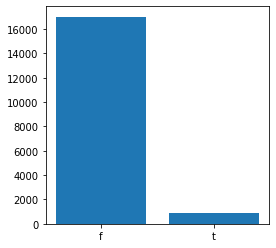

In [5]:
plt.figure(figsize=(4, 4))
plt.bar(['f', 't'], list(datafull['fraudulent'].value_counts()[:2]))

In [6]:
datafull['fraudulent'].value_counts()

f    17014
t      866
Name: fraudulent, dtype: int64

## Analysis of missing values in each variable

In [7]:
datafull.isnull().sum()/(len(datafull))

title                  0.000000
location               0.019351
department             0.645805
salary_range           0.839597
company_profile        0.185011
description            0.000000
requirements           0.150391
benefits               0.402461
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
employment_type        0.194128
required_experience    0.394295
required_education     0.453300
industry               0.274217
function               0.361018
fraudulent             0.000000
in_balanced_dataset    0.000000
dtype: float64

We notice some features like department and education have very high missing values and are hard to predict. Therefore we decide to drop them.

## Dropping other variables

For our model, we want to maintain regularization and hence we remove location, required_experience, required_education, industry and function too. 

In [8]:
datafull.drop(columns = ['department', 'location', 'employment_type', 'required_experience', 'required_education', 'industry', 'function'], axis = 1, inplace=True)

## Checking missing values again

In [9]:
datafull.isnull().sum()/(len(datafull))

title                  0.000000
salary_range           0.839597
company_profile        0.185011
description            0.000000
requirements           0.150391
benefits               0.402461
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
fraudulent             0.000000
in_balanced_dataset    0.000000
dtype: float64

## Analyzing the missing values

We notice that we only have missing values in company_profile, requirements, benefits and salary. For the first 3: It is in our interest that these missing values may belong more to the fraudulent jobs and can be used as a feature in our prediction. For Salary, we will work on predicting it through text as well.

In [10]:
fraudulent_jobs = datafull[datafull.fraudulent=='t']
non_fraudulent_jobs = datafull[datafull.fraudulent=='f']

In [11]:
fraudulent_jobs.isnull().sum()/(len(datafull[datafull.fraudulent=='t']))

title                  0.000000
salary_range           0.742494
company_profile        0.677829
description            0.000000
requirements           0.176674
benefits               0.419169
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
fraudulent             0.000000
in_balanced_dataset    0.000000
dtype: float64

In [12]:
non_fraudulent_jobs.isnull().sum()/(len(datafull[datafull.fraudulent=='f']))

title                  0.000000
salary_range           0.844540
company_profile        0.159927
description            0.000000
requirements           0.149054
benefits               0.401610
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
fraudulent             0.000000
in_balanced_dataset    0.000000
dtype: float64

## Replace any nan values present in the dataframe with empty strings 

The 3 variables containing the missing values are text data. Therefore we can replace the nan values with empty strings[length =0]

In [13]:
datafull = datafull.replace(np.nan, '')

In [14]:
datafull.isnull().sum()

title                  0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
fraudulent             0
in_balanced_dataset    0
dtype: int64

## Preprocessing HTML data

The variables company_profile, description, requirements and benefits are in the form of html data. We preprocess these text by:
1. Case folding the text: make_lower()
2. Removing br tags: remove_br()
3. Stripping html tags: clean_html()
4. Removing non-ascii characters: remove_non_ascii()
5. Removing url patterns: remove_junk()
6. Removing punctuations: remove_punct()
7. Removing escapes: remove_escape()
8. Removing digits: remove_digits()
9. Detecting foreign languages. We remove them from the dataset

We perform the preprocessing and store them into new variables: preprocessed_company_profile, preprocessed_description, preprocessed_requirements and preprocessed_benefits respectively. We also create a new variable called full_text which is a contacatenated value of all the preprocessed text variables.

In [15]:
def make_lower(text):
    a = text.lower()
    return(a)

def clean_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def remove_punct(text):
    text = strip_punctuation(text)           
    return (text)

def remove_non_ascii(text):
    decoded = re.sub(r'[^\x00-\x7F]+[a-z]*',' ', text)
    return decoded

def remove_junk(text):
    text = re.sub(r'url_[a-z0-9]+', ' ', text)
    text = re.sub(r'email_[a-z0-9]+', ' ', text)
    text = re.sub(r'phone_[a-z0-9]+', ' ', text)
    return text

def remove_br(text):
    text = re.sub(r'<br>+', ' ', text)
    return text

def remove_escapes(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_digits(text):
    text = re.sub(r'\d+', '', text)
    return(text)

def find_language(text):
    return detect(text)

def stopwords_removal(text):
    return remove_stopwords(text)

def stem_sentences(text):
    p=PorterStemmer()
    return p.stem(text)

def preprocessing(text):
    text = text.apply(make_lower)
    text = text.apply(remove_br)
    text = text.apply(clean_html)
    text = text.apply(remove_non_ascii)
    text = text.apply(remove_junk)
    text = text.apply(remove_punct)
    text = text.apply(remove_escapes)
    text = text.apply(remove_digits)
    text=text.apply(stopwords_removal)
    text=text.apply(stem_sentences)
    return text

In [16]:
datafull['preprocessed_description'] = preprocessing(datafull['description'])
datafull['preprocessed_company_profile'] = preprocessing(datafull['company_profile'])
datafull['preprocessed_requirements'] = preprocessing(datafull['requirements'])
datafull['preprocessed_benefits'] = preprocessing(datafull['benefits'])
datafull['preprocessed_title'] = preprocessing(datafull['title'])

datafull['full_text'] = datafull['preprocessed_description'] + datafull['preprocessed_company_profile'] + datafull['preprocessed_requirements'] + datafull['preprocessed_benefits']

datafull['language'] = datafull['full_text'].apply(find_language)

datafull = datafull[datafull.language == "en"]
datafull.index = range(0,len(datafull))

##### Transforming salary range to numeric figures

In [17]:
salarypoint=[]
salarylower=[]
salaryupper=[]
for i in datafull['salary_range']:
    sal=float("NaN")
    lsal=float("NaN")
    usal=float("NaN")
    if i and type(i)==str:
        matched=re.match('([0-9])+000-([0-9])+000',i)
        if matched:
            l=matched.group(0).split('-')
            lsal=int(l[0])
            usal=int(l[1])
            sal=(lsal+usal)/2
    salarypoint.append(sal)
    salarylower.append(lsal)
    salaryupper.append(usal)

datafull['salary_point']=salarypoint
datafull['salary_lower']=salarylower
datafull['salary_upper']=salaryupper

In [18]:
NotNull=[i for i,e in enumerate(salarypoint) if e>0]
X = np.array(datafull.loc[NotNull, 'full_text'])
y = np.array(datafull.loc[NotNull, ['salary_point','salary_lower','salary_upper']])

minsal=min([i[1] for i in y])
maxsal=max([i[2] for i in y])
classes=range(int(minsal),int(maxsal),20000)

## Getting a more balanced dataset
<i>The data here is highly skewed towards the non-fraudulent jobs. Therefore, we sample all fraudulent jobs along with all genuine jobs that already have salaries (in that way we reduce the error of the salary predictor creeping into our final data once it is used) </i>

In [19]:
data = pd.concat([datafull[datafull.fraudulent=='t'],datafull.loc[NotNull,][datafull.fraudulent=='f']])
data.index = range(0,len(data))

<BarContainer object of 2 artists>

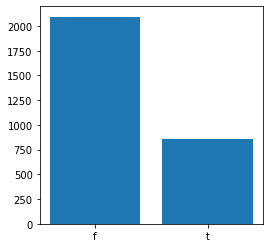

In [20]:
plt.figure(figsize=(4, 4))
plt.bar(['f', 't'], list(data['fraudulent'].value_counts()[:2]))

## Bag of words model

First we build a bag of words model using th full_text variable created. 

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import classification_report

In [22]:
text_datafull = datafull['full_text']
tokenfull = RegexpTokenizer(r'[a-zA-Z0-9]+')

## Bag of words model - Baseline

In [23]:
text_data = data['full_text']
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
vect = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
bow = vect.fit_transform(text_data)
bow = bow.toarray()

### Splitting the dataset into train and test

In [24]:
bow_train, bow_test, data_train, data_test = train_test_split(bow, data, test_size = 0.3, random_state = 0)

In [25]:
X_train0=bow_train
X_test0=bow_test
y_train = data_train['fraudulent']=="t"
y_test = data_test['fraudulent']=="t"

In [26]:
clfs = [MultinomialNB(),LogisticRegression(),LinearSVC(),KNeighborsClassifier(),RandomForestClassifier()]
models=['NB','LR','SVC','K-NN','RF']

In [27]:
for i,clf in enumerate(clfs):
    clf.fit(X_train0, y_train)
    # infer the label of each instance in the test set
    predictions = clf.predict(X_test0)
    print(models[i])
    print(classification_report(y_test, predictions))

NB
              precision    recall  f1-score   support

       False       0.96      0.93      0.94       623
        True       0.85      0.90      0.87       263

    accuracy                           0.92       886
   macro avg       0.90      0.91      0.91       886
weighted avg       0.92      0.92      0.92       886

LR
              precision    recall  f1-score   support

       False       0.96      0.96      0.96       623
        True       0.91      0.89      0.90       263

    accuracy                           0.94       886
   macro avg       0.93      0.93      0.93       886
weighted avg       0.94      0.94      0.94       886

SVC
              precision    recall  f1-score   support

       False       0.95      0.95      0.95       623
        True       0.88      0.89      0.88       263

    accuracy                           0.93       886
   macro avg       0.91      0.92      0.92       886
weighted avg       0.93      0.93      0.93       886

K-NN
    

In [28]:
del X_train0
del X_test0

## Looking at the term and bigram frequencies of the text in fraudulent and non-fraudulent data to understand the underlying situation.

In [29]:
fraudulent_jobs = data_train[data_train.fraudulent=='t']
non_fraudulent_jobs = data_train[data_train.fraudulent=='f']

In [30]:
import matplotlib.pyplot as plt
from collections import Counter
import operator
def termfreq(input,n):
    word_list=[]
    word_list.append([i  for j in input for i in j.split()])
    counts_all = Counter(word_list[0])
    
    words, count_values = zip(*counts_all.items())
    
    # http://stackoverflow.com/questions/9543211/sorting-a-list-in-python-using-the-result-from-sorting-another-list
    values_s, words_s = zip(*sorted(zip(count_values, words), key=operator.itemgetter(0), reverse=True))
    
    # Top N
    words_s_top = words_s[0:n]
    values_s_top = values_s[0:n]
    
    df = pd.DataFrame({'count': values_s_top, 'word': words_s_top})
    print(df)
  
    fig1 = plt.figure()
    fig1.suptitle('term frequency plot', fontsize=16)
    plt.xlabel('frequency rank', fontsize=12)
    plt.ylabel('frequency', fontsize=12)
    plt.plot(values_s)
    plt.show()

    fig2 = plt.figure()
    fig2.suptitle('term frequency plot log-log', fontsize=16)
    plt.xlabel('frequency rank', fontsize=12)
    plt.ylabel('frequency', fontsize=12)
    plt.plot(values_s)
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

In [31]:
def bigramfreq(input,n):
    bigram_list=[]
    bigram_list.append([" ".join((j.split()[i-1],j.split()[i]))  for j in input for i in range(len(j.split()[1:]))])
    counts_all = Counter(bigram_list[0])
    
    bigrams, count_values = zip(*counts_all.items())
    
    # http://stackoverflow.com/questions/9543211/sorting-a-list-in-python-using-the-result-from-sorting-another-list
    values_s, bigrams_s = zip(*sorted(zip(count_values, bigrams), key=operator.itemgetter(0), reverse=True))
    
    # Top N
    bigrams_s_top = bigrams_s[0:n]
    values_s_top = values_s[0:n]
    
    df = pd.DataFrame({'count': values_s_top, 'bigram': bigrams_s_top})
    print(df)
  
    fig1 = plt.figure()
    fig1.suptitle('bigrams frequency plot', fontsize=16)
    plt.xlabel('frequency rank', fontsize=12)
    plt.ylabel('frequency', fontsize=12)
    plt.plot(values_s)
    plt.show()

    fig2 = plt.figure()
    fig2.suptitle('bigrams frequency plot log-log', fontsize=16)
    plt.xlabel('frequency rank', fontsize=12)
    plt.ylabel('frequency', fontsize=12)
    plt.plot(values_s)
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

   count         word
0   4168   experience
1   3674         work
2   3348         team
3   2111     business
4   2031      company
5   2026       skills
6   1962        sales
7   1894          new
8   1890  development
9   1843   management


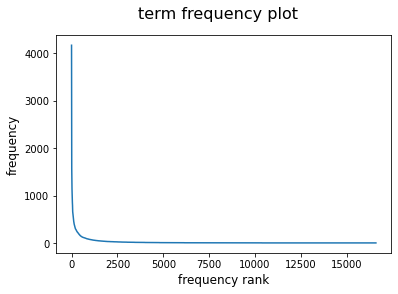

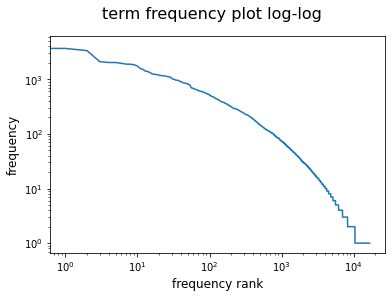

   count                bigram
0    423  communication skills
1    403      years experience
2    348          social media
3    340      customer service
4    251          ability work
5    235          fast growing
6    222            fast paced
7    222             long term
8    206  software development
9    204    experience working


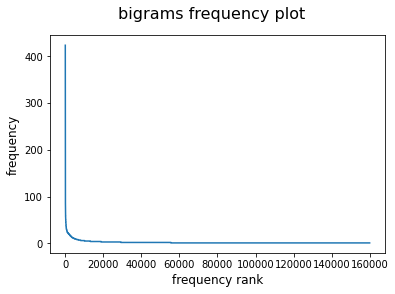

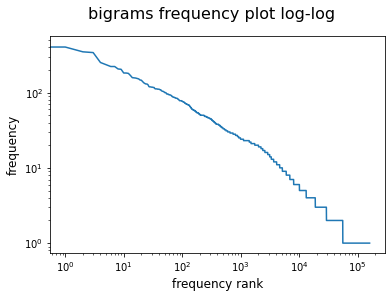

In [32]:
non_fraudulent_words_title = non_fraudulent_jobs.full_text.values
termfreq(non_fraudulent_words_title,10)
bigramfreq(non_fraudulent_words_title,10)

   count        word
0   1177        work
1   1110  experience
2    858      skills
3    612     company
4    588        team
5    524        time
6    517     ability
7    500  management
8    489     service
9    463    business


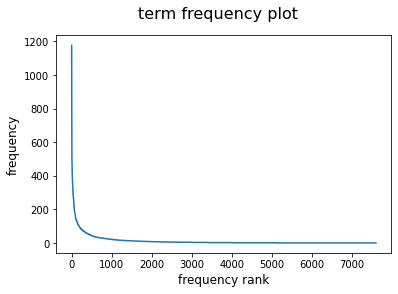

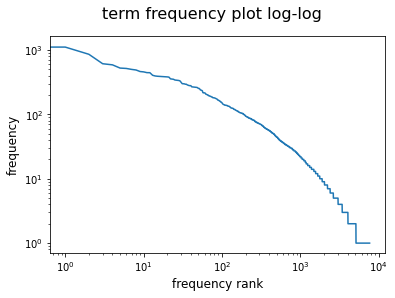

   count                bigram
0    194      customer service
1    186            data entry
2    166               oil gas
3    147  communication skills
4    135        aker solutions
5    120      years experience
6    112          gas industry
7    107          ability work
8     88             work home
9     84             able work


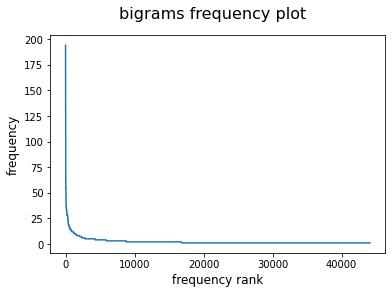

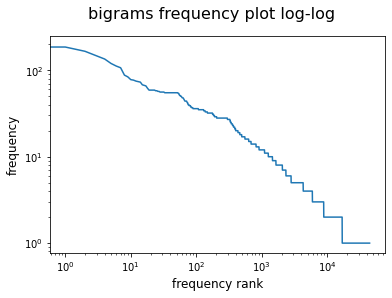

In [33]:
fraudulent_words_title = fraudulent_jobs.full_text.values
termfreq(fraudulent_words_title,10)
bigramfreq(fraudulent_words_title,10)

Consider downweighting the effect of common words by using binary values and by using tf*idf

#Transforming frequencies to binary

In [34]:
bbow_train=bow_train.copy()
bbow_test=bow_test.copy()

In [35]:
for i in range(len(bbow_train)):
    bbow_train[i]=bbow_train[i]>0

In [36]:
for i in range(len(bbow_test)):
    bbow_test[i]=bbow_test[i]>0

###Models with Binary BOW

In [37]:
X_train0B=bbow_train
X_test0B=bbow_test

In [38]:
for i,clf in enumerate(clfs):
    clf.fit(X_train0B, y_train)
    # infer the label of each instance in the test set
    predictions = clf.predict(X_test0B)
    print(models[i])
    print(classification_report(y_test, predictions))

NB
              precision    recall  f1-score   support

       False       0.95      0.94      0.95       623
        True       0.86      0.89      0.88       263

    accuracy                           0.93       886
   macro avg       0.91      0.92      0.91       886
weighted avg       0.93      0.93      0.93       886

LR
              precision    recall  f1-score   support

       False       0.95      0.97      0.96       623
        True       0.92      0.89      0.90       263

    accuracy                           0.94       886
   macro avg       0.94      0.93      0.93       886
weighted avg       0.94      0.94      0.94       886

SVC
              precision    recall  f1-score   support

       False       0.95      0.96      0.96       623
        True       0.91      0.89      0.90       263

    accuracy                           0.94       886
   macro avg       0.93      0.93      0.93       886
weighted avg       0.94      0.94      0.94       886

K-NN
    

In [39]:
del X_train0B
del X_test0B

##Transforming frequencies to tf*idf

In [40]:
docf=[]
for i in range(len(bow[0])):
  docf.append(0)
  for doc in bow:
    docf[i]+=doc[i]

In [41]:
tdm_train=bow_train.copy()
tdm_test=bow_test.copy()

In [42]:
import math
for i in range(len(tdm_train)):
    for e,freq in enumerate(tdm_train[i]):
        tdm_train[i][e] = tdm_train[i][e]*math.log(len(docf)/docf[e],2.0)

In [43]:
for i in range(len(tdm_test)):
    for e,freq in enumerate(tdm_test[i]):
        tdm_test[i][e] = tdm_test[i][e]*math.log(len(docf)/docf[e],2.0)

### Models for the TDM with tf*idf 

In [44]:
X_train1=tdm_train
X_test1=tdm_test

In [45]:
for i,clf in enumerate(clfs):
    clf.fit(X_train1, y_train)
    # infer the label of each instance in the test set
    predictions = clf.predict(X_test1)
    print(models[i])
    print(classification_report(y_test, predictions))

NB
              precision    recall  f1-score   support

       False       0.97      0.93      0.95       623
        True       0.85      0.94      0.89       263

    accuracy                           0.93       886
   macro avg       0.91      0.93      0.92       886
weighted avg       0.94      0.93      0.93       886

LR
              precision    recall  f1-score   support

       False       0.96      0.97      0.96       623
        True       0.93      0.89      0.91       263

    accuracy                           0.95       886
   macro avg       0.94      0.93      0.94       886
weighted avg       0.95      0.95      0.95       886

SVC
              precision    recall  f1-score   support

       False       0.96      0.96      0.96       623
        True       0.91      0.91      0.91       263

    accuracy                           0.95       886
   macro avg       0.94      0.94      0.94       886
weighted avg       0.95      0.95      0.95       886

K-NN
    

In [46]:
del X_train1
del X_test1

## Checking for useful derived features to add

###### Derived from preprocessed_description, preprocessed_company_profile, preprocessed_requirements, preprocessed_benefits variables:
1. desc_length
2. company_profile_length
3. requirements_length
4. benefits_length

###### Derived from description, requirement, benefits variables:
5. desc_emp_tag_count
6. req_emp_tag_count
7. benefits_emp_tag_count
8. requirements_list_tag_count
9. benefits_list_tag_count

###### Binary Variables availble in the dataset:
10. telecommuting: 0 or 1
11. has_company_logo: 0 or 1
12. has_questions: 0 or 1

### Creating Length Features

It is also worth checking if text metadata is indicative of fraud

In [47]:
def text_length(text):
    return (len(text))

def find_emphasize_len(text):
    emphasize_tags = ['b', 'em', 'strong']
    emp_list = []

    if type(text) != float: 
        soup = BeautifulSoup(text, 'html.parser')
        for i in emphasize_tags:
            result = soup.find_all(i)
            emp_list.extend(result)
  
    if(emp_list):
        return len(emp_list)

    else:
        return 0

def find_list_len(text):
    list_tags = ['ul', 'li', 'ol', 'dl', 'dt', 'dd']
    list_list = []

    if type(text) != float:
        soup = BeautifulSoup(text, 'html.parser')
        for i in list_tags:
            result = soup.find_all(i)
            list_list.extend(result)
  
    if(list_list):
        return len(list_list)

    return 0


    

In [48]:
data_train['desc_length'] = data_train['preprocessed_description'].apply(text_length)
data_train['requirement_length'] = data_train['preprocessed_requirements'].apply(text_length)
data_train['benefits_length'] = data_train['preprocessed_benefits'].apply(text_length)
data_train['company_profile_length'] = data_train['preprocessed_company_profile'].apply(text_length)

In [49]:
data_test['desc_length'] = data_test['preprocessed_description'].apply(text_length)
data_test['requirement_length'] = data_test['preprocessed_requirements'].apply(text_length)
data_test['benefits_length'] = data_test['preprocessed_benefits'].apply(text_length)
data_test['company_profile_length'] = data_test['preprocessed_company_profile'].apply(text_length)

In [50]:
fraudulent_jobs = data_train[data_train.fraudulent=='t']
non_fraudulent_jobs = data_train[data_train.fraudulent=='f']

In [51]:
fraudulent_jobs['desc_length'].describe()

count     595.000000
mean      819.124370
std       745.272461
min         0.000000
25%       310.500000
50%       572.000000
75%      1070.000000
max      4975.000000
Name: desc_length, dtype: float64

In [52]:
non_fraudulent_jobs['desc_length'].describe()

count    1471.000000
mean      917.724677
std       616.609794
min        19.000000
25%       499.000000
50%       786.000000
75%      1178.000000
max      4586.000000
Name: desc_length, dtype: float64

In [53]:
fraudulent_jobs['requirement_length'].describe()

count     595.000000
mean      347.675630
std       446.180552
min         0.000000
25%        41.000000
50%       177.000000
75%       511.500000
max      3264.000000
Name: requirement_length, dtype: float64

In [54]:
non_fraudulent_jobs['requirement_length'].describe()

count    1471.000000
mean      489.191027
std       430.880493
min         0.000000
25%       184.000000
50%       406.000000
75%       665.500000
max      3531.000000
Name: requirement_length, dtype: float64

In [55]:
fraudulent_jobs['benefits_length'].describe()

count     595.000000
mean      135.663866
std       237.030204
min         0.000000
25%         0.000000
50%        22.000000
75%       161.000000
max      1612.000000
Name: benefits_length, dtype: float64

In [56]:
non_fraudulent_jobs['benefits_length'].describe()

count    1471.000000
mean      212.918423
std       298.033642
min         0.000000
25%         5.500000
50%       120.000000
75%       276.000000
max      3121.000000
Name: benefits_length, dtype: float64

In [57]:
fraudulent_jobs['company_profile_length'].describe()

count     595.000000
mean      153.073950
std       264.852957
min         0.000000
25%         0.000000
50%         0.000000
75%       259.000000
max      1018.000000
Name: company_profile_length, dtype: float64

In [58]:
non_fraudulent_jobs['company_profile_length'].describe()

count    1471.000000
mean      439.184908
std       402.773843
min         0.000000
25%        97.000000
50%       352.000000
75%       688.000000
max      2650.000000
Name: company_profile_length, dtype: float64

Based on the above, the only one that might be helpful is company profile length

In [59]:
data_train.company_profile_length[data_train.company_profile_length < 100] = 0
data_train.company_profile_length[data_train.company_profile_length >= 100] = 1

In [60]:
data_test.company_profile_length[data_test.company_profile_length < 100] = 0
data_test.company_profile_length[data_test.company_profile_length >= 100] = 1

### Creating html features

It is also worth looking if htm features are indicative

In [61]:
data_train['desc_emp_tag_count'] = data_train['description'].apply(find_emphasize_len)
data_train['req_emp_tag_count'] = data_train['requirements'].apply(find_emphasize_len)
data_train['benefits_emp_tag_count'] = data_train['benefits'].apply(find_emphasize_len)
data_train['req_list_tag_count'] = data_train['requirements'].apply(find_list_len)
data_train['benefits_list_tag_count'] = data_train['benefits'].apply(find_list_len)

In [62]:
data_test['desc_emp_tag_count'] = data_test['description'].apply(find_emphasize_len)
data_test['req_emp_tag_count'] = data_test['requirements'].apply(find_emphasize_len)
data_test['benefits_emp_tag_count'] = data_test['benefits'].apply(find_emphasize_len)
data_test['req_list_tag_count'] = data_test['requirements'].apply(find_list_len)
data_test['benefits_list_tag_count'] = data_test['benefits'].apply(find_list_len)

In [63]:
fraudulent_jobs = data_train[data_train.fraudulent=='t']
non_fraudulent_jobs = data_train[data_train.fraudulent=='f']

In [64]:
fraudulent_jobs['desc_emp_tag_count'].describe()

count    595.000000
mean       1.858824
std        5.457232
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       97.000000
Name: desc_emp_tag_count, dtype: float64

In [65]:
non_fraudulent_jobs['desc_emp_tag_count'].describe()

count    1471.000000
mean        1.800816
std         2.940063
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        37.000000
Name: desc_emp_tag_count, dtype: float64

In [66]:
fraudulent_jobs['req_emp_tag_count'].describe()

count    595.000000
mean       0.569748
std        1.780863
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       29.000000
Name: req_emp_tag_count, dtype: float64

In [67]:
non_fraudulent_jobs['req_emp_tag_count'].describe()

count    1471.000000
mean        0.760707
std         1.612403
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        26.000000
Name: req_emp_tag_count, dtype: float64

In [68]:
fraudulent_jobs['benefits_emp_tag_count'].describe()

count    595.000000
mean       0.448739
std        1.527077
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       29.000000
Name: benefits_emp_tag_count, dtype: float64

In [69]:
non_fraudulent_jobs['benefits_emp_tag_count'].describe()

count    1471.000000
mean        0.488103
std         1.293506
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: benefits_emp_tag_count, dtype: float64

In [70]:
fraudulent_jobs['req_list_tag_count'].describe()

count    595.000000
mean       2.465546
std        6.133482
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       54.000000
Name: req_list_tag_count, dtype: float64

In [71]:
non_fraudulent_jobs['req_list_tag_count'].describe()

count    1471.000000
mean        7.099252
std         7.682718
min         0.000000
25%         0.000000
50%         6.000000
75%        11.000000
max        61.000000
Name: req_list_tag_count, dtype: float64

In [72]:
fraudulent_jobs['benefits_list_tag_count'].describe()

count    595.000000
mean       0.857143
std        2.955010
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       16.000000
Name: benefits_list_tag_count, dtype: float64

In [73]:
non_fraudulent_jobs['benefits_list_tag_count'].describe()

count    1471.000000
mean        2.547927
std         3.947648
min         0.000000
25%         0.000000
50%         0.000000
75%         5.000000
max        32.000000
Name: benefits_list_tag_count, dtype: float64

Based on the above, requirement list tag count and benefit list tag count shall be used only

### Binary variables

Investigation of binary variables' usefullness

In [74]:
data_train.telecommuting[data_train.telecommuting == 'f'] = 0
data_train.telecommuting[data_train.telecommuting == 't'] = 1
data_train.has_company_logo[data_train.has_company_logo == 'f'] = 0
data_train.has_company_logo[data_train.has_company_logo == 't'] = 1
data_train.has_questions[data_train.has_questions == 'f'] = 0
data_train.has_questions[data_train.has_questions == 't'] = 1

In [75]:
data_test.telecommuting[data_test.telecommuting == 'f'] = 0
data_test.telecommuting[data_test.telecommuting == 't'] = 1
data_test.has_company_logo[data_test.has_company_logo == 'f'] = 0
data_test.has_company_logo[data_test.has_company_logo == 't'] = 1
data_test.has_questions[data_test.has_questions == 'f'] = 0
data_test.has_questions[data_test.has_questions == 't'] = 1

In [76]:
fraudulent_jobs = data_train[data_train.fraudulent=='t']
non_fraudulent_jobs = data_train[data_train.fraudulent=='f']

In [77]:
sum(fraudulent_jobs['telecommuting'])/len(fraudulent_jobs)

0.08907563025210084

In [78]:
sum(non_fraudulent_jobs['telecommuting'])/len(non_fraudulent_jobs)

0.07817811012916383

In [79]:
sum(fraudulent_jobs['has_company_logo'])/len(fraudulent_jobs)

0.31932773109243695

In [80]:
sum(non_fraudulent_jobs['has_company_logo'])/len(non_fraudulent_jobs)

0.7715839564921821

In [81]:
sum(fraudulent_jobs['has_questions'])/len(fraudulent_jobs)

0.292436974789916

In [82]:
sum(non_fraudulent_jobs['has_questions'])/len(non_fraudulent_jobs)

0.5288919102651257

Based on the above, company logo and questions are worth keeping

###### Making Salaries Categorical for easier prediction

In [83]:
import tensorflow as tf
y2=tf.keras.utils.to_categorical([(i[0]-minsal)/20000 for i in y], num_classes=len(classes))

##### Prepare X and y Data for Salary prediction (simple BOW model will be used only)

In [84]:
count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = tokenfull.tokenize)

X_counts = count_vectorizer.fit_transform(X)

In [85]:
X_train, X_test, y_train, y_test, = train_test_split(X_counts, y2, test_size=0.2, random_state=0)

X_train.sort_indices()

### Train Neural Network to obtain salary

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import MeanSquaredError

input_dim = X_train.shape[1]

NN=Sequential()
NN.add(Dense(32,input_dim=input_dim,activation='relu'))
NN.add(Dense(60000,activation='softmax'))
NN.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
NN.fit(X_train.toarray(),y_train,epochs=20,batch_size=32)

X_test.sort_indices()
y_predict=NN.predict(X_test.toarray())

Epoch 1/20
57/57 [==============================] - 3s 47ms/step - loss: 6.2857 - accuracy: 0.2530
Epoch 2/20
57/57 [==============================] - 3s 46ms/step - loss: 2.5244 - accuracy: 0.2984
Epoch 3/20
57/57 [==============================] - 3s 46ms/step - loss: 2.1427 - accuracy: 0.4264
Epoch 4/20
57/57 [==============================] - 3s 45ms/step - loss: 1.7856 - accuracy: 0.5282
Epoch 5/20
57/57 [==============================] - 3s 45ms/step - loss: 1.4762 - accuracy: 0.6085
Epoch 6/20
57/57 [==============================] - 3s 45ms/step - loss: 1.2301 - accuracy: 0.6855
Epoch 7/20
57/57 [==============================] - 3s 44ms/step - loss: 0.9999 - accuracy: 0.7630
Epoch 8/20
57/57 [==============================] - 3s 45ms/step - loss: 0.8173 - accuracy: 0.8223
Epoch 9/20
57/57 [==============================] - 3s 45ms/step - loss: 0.6730 - accuracy: 0.8666
Epoch 10/20
57/57 [==============================] - 3s 44ms/step - loss: 0.5518 - accuracy: 0.8898
Epoch 11/

In [87]:
del X_train
del X_test

##### Check Accuracy

In [88]:
ind=[]
for i in y_predict:
  inde = list(i).index(max(i))
  ind.append(inde)
               
ind2=[]
for i in y_test:
  inde = list(i).index(max(i))
  ind2.append(inde)

y_predictp=np.multiply(ind,20000)+minsal
y_testp=np.multiply(ind2,20000)+minsal

acc=[]
for i in range(len(y_predict)):
    if y_predictp[i]>=y_testp[i]-40000 and y_predictp[i]<=y_testp[i]+40000:
        acc.append(1)
    else:
        acc.append(0)

print(sum(acc)/len(acc))

0.8915929203539823


Accuracy is satisfactory. Time to predict.

In [89]:
X_predict_train = np.array(data_train[data_train['salary_point'].isna()]['full_text'])

X_predict_train_counts = count_vectorizer.transform(X_predict_train)
X_predict_train_counts.sort_indices()

predicted_salaries_train = NN.predict(X_predict_train_counts.toarray())
cat_pred_train=[]
for i in predicted_salaries_train:
  cat = list(i).index(max(i))
  cat_pred_train.append(cat)

point_predictions_train=np.multiply(cat_pred_train,20000)+minsal



In [90]:
X_predict_test = np.array(data_test[data_test['salary_point'].isna()]['full_text'])

X_predict_test_counts = count_vectorizer.transform(X_predict_test)
X_predict_test_counts.sort_indices()

predicted_salaries_test = NN.predict(X_predict_test_counts.toarray())
cat_pred_test=[]
for i in predicted_salaries_test:
  cat = list(i).index(max(i))
  cat_pred_test.append(cat)

point_predictions_test=np.multiply(cat_pred_test,20000)+minsal

In [91]:
data_train['predicted_salary']=0
data_train['predicted_salary'][data_train['salary_point'].isna()]=point_predictions_train
data_train['predicted_salary'][data_train['salary_point']>0]=data_train[data_train['salary_point']>0]['salary_point']

In [92]:
data_test['predicted_salary']=0
data_test['predicted_salary'][data_test['salary_point'].isna()]=point_predictions_test
data_test['predicted_salary'][data_test['salary_point']>0]=data_test[data_test['salary_point']>0]['salary_point']

## Creating HMM features

Processing for tagging

In [93]:
def preprocessing_2(text):
    text = text.apply(make_lower)
    text = text.apply(remove_br)
    text = text.apply(clean_html)
    text = text.apply(remove_non_ascii)
    text = text.apply(remove_junk)
    text = text.apply(remove_escapes)
    return text

In [94]:
data_train['full_text_structured'] = preprocessing_2(data_train['full_text'])

In [95]:
data_test['full_text_structured'] = preprocessing_2(data_test['full_text'])

Using the tagger to capture average log probability per sentence of observing particular set of tags in each ad

In [96]:
from nltk.corpus import treebank
nltk.download('treebank')
train_data = treebank.tagged_sents()
trainer = hmm.HiddenMarkovModelTrainer()
tagger = trainer.train_supervised(train_data)
tagger = nltk.HiddenMarkovModelTagger.train(train_data)

def sent_calculation(text):
    prob = 0
    sent_list = str(text).split(".")
    for i in range(len(sent_list)):
        test = tagger.tag(sent_list[i].split())
        prob = prob + tagger.log_probability(test)
    return prob

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


In [97]:
data_train['awkward_lang'] = data_train['full_text_structured'].apply(sent_calculation)

In [98]:
data_test['awkward_lang'] = data_test['full_text_structured'].apply(sent_calculation)

In [99]:
fraudulent_jobs = data_train[data_train.fraudulent=='t']
non_fraudulent_jobs = data_train[data_train.fraudulent=='f']

In [100]:
fraudulent_jobs['awkward_lang'].describe()

count      595.000000
mean     -2631.885880
std       2000.864472
min     -11101.280907
25%      -3625.807656
50%      -2120.131474
75%      -1162.698445
max        -79.420798
Name: awkward_lang, dtype: float64

In [101]:
non_fraudulent_jobs['awkward_lang'].describe()

count     1471.000000
mean     -3803.628721
std       1966.618756
min     -13944.396940
25%      -4783.173309
50%      -3538.783918
75%      -2457.601623
max       -115.849778
Name: awkward_lang, dtype: float64

Based on the above there seems to be some difference. So we shall look into adding this feature

## Model: tf*idf + Derived Features

In [102]:
def Encode_features2(mtrx, data):
    features = []
    
    for i in range(len(data)):
        tmp = [ data['has_company_logo'].iloc[i], data['has_questions'].iloc[i], data['company_profile_length'].iloc[i], data['benefits_list_tag_count'].iloc[i], data['req_list_tag_count'].iloc[i]]
        tmp.extend(list(mtrx[i]))
        features.append(tmp)
    return features

In [103]:
X_train2 = Encode_features2(tdm_train, data_train)
X_test2 = Encode_features2(tdm_test, data_test)
y_train = data_train['fraudulent']=="t"
y_test = data_test['fraudulent']=="t"

In [104]:
for i,clf in enumerate(clfs):
    clf.fit(X_train2, y_train)
    # infer the label of each instance in the test set
    predictions = clf.predict(X_test2)
    print(models[i])
    print(classification_report(y_test, predictions))

NB
              precision    recall  f1-score   support

       False       0.97      0.94      0.95       623
        True       0.86      0.94      0.90       263

    accuracy                           0.94       886
   macro avg       0.92      0.94      0.92       886
weighted avg       0.94      0.94      0.94       886

LR
              precision    recall  f1-score   support

       False       0.96      0.96      0.96       623
        True       0.91      0.90      0.91       263

    accuracy                           0.94       886
   macro avg       0.94      0.93      0.93       886
weighted avg       0.94      0.94      0.94       886

SVC
              precision    recall  f1-score   support

       False       0.96      0.95      0.96       623
        True       0.89      0.90      0.90       263

    accuracy                           0.94       886
   macro avg       0.93      0.93      0.93       886
weighted avg       0.94      0.94      0.94       886

K-NN
    

In [105]:
del X_train2
del X_test2

## Model: Only derived features

In [106]:
def Encode_features3(mtrx, data):
    features = []
    
    for i in range(len(data)):
        tmp = [ data['has_company_logo'].iloc[i], data['has_questions'].iloc[i], data['company_profile_length'].iloc[i], data['benefits_list_tag_count'].iloc[i], data['req_list_tag_count'].iloc[i]]
        features.append(tmp)
    return features

In [107]:
X_train3 = Encode_features3(False, data_train)
X_test3 = Encode_features3(False, data_test)

In [108]:
for i,clf in enumerate(clfs):
    clf.fit(X_train3, y_train)
    # infer the label of each instance in the test set
    predictions = clf.predict(X_test3)
    print(models[i])
    print(classification_report(y_test, predictions))

NB
              precision    recall  f1-score   support

       False       0.70      1.00      0.83       623
        True       0.00      0.00      0.00       263

    accuracy                           0.70       886
   macro avg       0.35      0.50      0.41       886
weighted avg       0.49      0.70      0.58       886

LR
              precision    recall  f1-score   support

       False       0.84      0.87      0.85       623
        True       0.66      0.59      0.62       263

    accuracy                           0.79       886
   macro avg       0.75      0.73      0.74       886
weighted avg       0.78      0.79      0.78       886

SVC
              precision    recall  f1-score   support

       False       0.84      0.87      0.85       623
        True       0.66      0.60      0.63       263

    accuracy                           0.79       886
   macro avg       0.75      0.74      0.74       886
weighted avg       0.79      0.79      0.79       886

K-NN
    

In [109]:
del X_train3
del X_test3

## Model: tf*idf + derived features + salary predictions

In [110]:
def Encode_features4(mtrx, data):
    features = []
    
    for i in range(len(data)):
        tmp = [ data['has_company_logo'].iloc[i], data['has_questions'].iloc[i], data['company_profile_length'].iloc[i], data['benefits_list_tag_count'].iloc[i], data['req_list_tag_count'].iloc[i], data['predicted_salary'].iloc[i]]
        tmp.extend(list(mtrx[i]))
        features.append(tmp)
    return features

In [111]:
X_train4 = Encode_features4(tdm_train, data_train)
X_test4 = Encode_features4(tdm_test, data_test)

In [112]:
for i,clf in enumerate(clfs):
    clf.fit(X_train4, y_train)
    # infer the label of each instance in the test set
    predictions = clf.predict(X_test4)
    print(models[i])
    print(classification_report(y_test, predictions))

NB
              precision    recall  f1-score   support

       False       0.89      0.13      0.23       623
        True       0.32      0.96      0.48       263

    accuracy                           0.38       886
   macro avg       0.60      0.55      0.35       886
weighted avg       0.72      0.38      0.30       886

LR
              precision    recall  f1-score   support

       False       0.93      0.97      0.95       623
        True       0.93      0.84      0.88       263

    accuracy                           0.93       886
   macro avg       0.93      0.90      0.92       886
weighted avg       0.93      0.93      0.93       886

SVC
              precision    recall  f1-score   support

       False       0.83      0.92      0.87       623
        True       0.75      0.54      0.63       263

    accuracy                           0.81       886
   macro avg       0.79      0.73      0.75       886
weighted avg       0.80      0.81      0.80       886

K-NN
    

In [113]:
del X_train4
del X_test4

## Model: tf*idf + derived features + Salary + HMM probabilities

In [114]:
def Encode_features5(mtrx, data):
    features = []
    
    for i in range(len(data)):
        tmp = [ data['has_company_logo'].iloc[i], data['has_questions'].iloc[i], data['company_profile_length'].iloc[i], data['benefits_list_tag_count'].iloc[i], data['req_list_tag_count'].iloc[i],  data['predicted_salary'].iloc[i], -1*data['awkward_lang'].iloc[i]]
        tmp.extend(list(mtrx[i]))
        features.append(tmp)
    return features

In [115]:
X_train5 = Encode_features5(tdm_train, data_train)
X_test5 = Encode_features5(tdm_test, data_test)

In [116]:
for i,clf in enumerate(clfs):
    clf.fit(X_train5, y_train)
    # infer the label of each instance in the test set
    predictions = clf.predict(X_test5)
    print(models[i])
    print(classification_report(y_test, predictions))

NB
              precision    recall  f1-score   support

       False       0.81      0.10      0.18       623
        True       0.31      0.94      0.46       263

    accuracy                           0.35       886
   macro avg       0.56      0.52      0.32       886
weighted avg       0.66      0.35      0.27       886

LR
              precision    recall  f1-score   support

       False       0.93      0.96      0.94       623
        True       0.89      0.84      0.86       263

    accuracy                           0.92       886
   macro avg       0.91      0.90      0.90       886
weighted avg       0.92      0.92      0.92       886

SVC
              precision    recall  f1-score   support

       False       0.94      0.42      0.58       623
        True       0.41      0.94      0.57       263

    accuracy                           0.57       886
   macro avg       0.67      0.68      0.57       886
weighted avg       0.78      0.57      0.58       886

K-NN
    

In [117]:
del X_train5
del X_test5

## Model: tf*idf + Salary + HMM probabilities

In [118]:
def Encode_features6(mtrx, data):
    features = []
    
    for i in range(len(data)):
        tmp = [ data['predicted_salary'].iloc[i], -1*data['awkward_lang'].iloc[i]]
        tmp.extend(list(mtrx[i]))
        features.append(tmp)
    return features

In [119]:
X_train6 = Encode_features6(tdm_train, data_train)
X_test6 = Encode_features6(tdm_test, data_test)

In [120]:
for i,clf in enumerate(clfs):
    clf.fit(X_train6, y_train)
    # infer the label of each instance in the test set
    predictions = clf.predict(X_test6)
    print(models[i])
    print(classification_report(y_test, predictions))

NB
              precision    recall  f1-score   support

       False       0.81      0.10      0.18       623
        True       0.31      0.94      0.46       263

    accuracy                           0.35       886
   macro avg       0.56      0.52      0.32       886
weighted avg       0.66      0.35      0.27       886

LR
              precision    recall  f1-score   support

       False       0.94      0.97      0.95       623
        True       0.93      0.84      0.88       263

    accuracy                           0.93       886
   macro avg       0.93      0.91      0.92       886
weighted avg       0.93      0.93      0.93       886

SVC
              precision    recall  f1-score   support

       False       0.72      1.00      0.83       623
        True       0.90      0.07      0.13       263

    accuracy                           0.72       886
   macro avg       0.81      0.53      0.48       886
weighted avg       0.77      0.72      0.62       886

K-NN
    

In [121]:
del X_train6
del X_test6